In [1]:
import numpy as np
import matplotlib.pyplot as plt

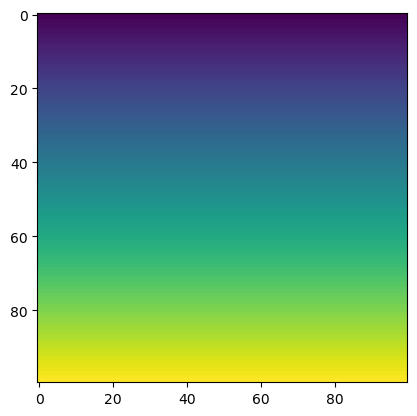

In [55]:
xx, yy = np.meshgrid(range(100), range(100))
z = yy
plt.imshow(z)

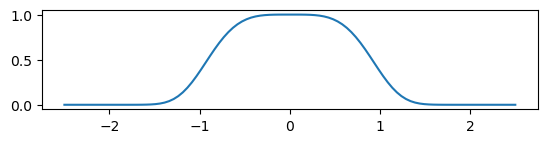

In [62]:
laser_start_points = [(0,50), (50,100)]
beam_normal_directions = [0,np.pi/2] # radians wrt x axis
ray_count_per_beam = 100

profile_range = -np.linspace(-2.5,2.5,ray_count_per_beam)
laser_profile = np.exp(-profile_range**4)

beams = list()
for beam_normal in beam_normal_directions:
    i_values = np.cos(beam_normal) * laser_profile
    j_values = np.sin(beam_normal) * laser_profile
    beams.append(list(zip(i_values, j_values)))

plt.plot(profile_range,laser_profile)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

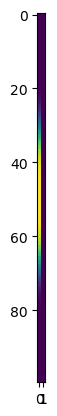

In [64]:
plt.imshow(beams[0])